# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


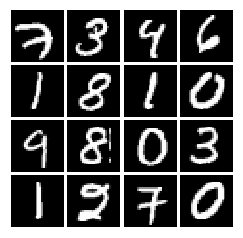

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, x * alpha)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    x = tf.random_uniform((batch_size, dim), minval=-1, maxval=1, dtype=tf.float32)
    return x


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        out = tf.layers.dense(inputs=x, units=256, activation=leaky_relu,
                                    use_bias=True, bias_initializer=tf.constant_initializer(0.0))
        out = tf.layers.dense(inputs=out, units=256, activation=leaky_relu,
                                    use_bias=True, bias_initializer=tf.constant_initializer(0.0))
        logits = tf.layers.dense(inputs=out, units=1,
                                    use_bias=True, bias_initializer=tf.constant_initializer(0.0))
        pass
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        out = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu,
                           use_bias=True, bias_initializer=tf.constant_initializer(0.0))
        out = tf.layers.dense(inputs=out, units=1024, activation=tf.nn.relu,
                           use_bias=True, bias_initializer=tf.constant_initializer(0.0))
        out = tf.layers.dense(inputs=out, units=784,
                           use_bias=True, bias_initializer=tf.constant_initializer(0.0))
        img = tf.tanh(out)
        pass
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    D_loss = (tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real)))
          + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake))) )
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake)))
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    pass
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

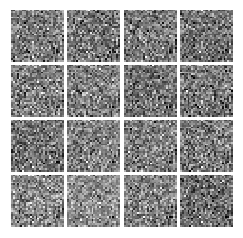


Iter: 0, D: 1.616, G:0.7462
Iter: 50, D: 0.6591, G:1.828
Iter: 100, D: 1.256, G:1.216
Iter: 150, D: 1.333, G:1.545
Iter: 200, D: 0.8594, G:1.309


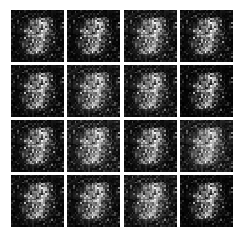


Iter: 250, D: 1.258, G:1.097
Iter: 300, D: 0.7826, G:1.825
Iter: 350, D: 0.6369, G:2.176
Iter: 400, D: 1.765, G:3.963
Iter: 450, D: 1.004, G:1.739


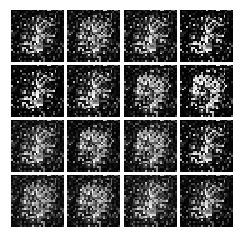


Iter: 500, D: 0.878, G:1.627
Iter: 550, D: 1.118, G:0.9653
Iter: 600, D: 2.125, G:0.9381
Iter: 650, D: 0.8943, G:1.505
Iter: 700, D: 1.254, G:1.169


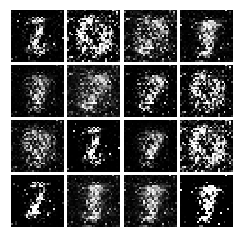


Iter: 750, D: 0.9591, G:1.526
Iter: 800, D: 1.078, G:1.417
Iter: 850, D: 1.199, G:1.21
Iter: 900, D: 1.306, G:1.216
Iter: 950, D: 0.9451, G:2.978


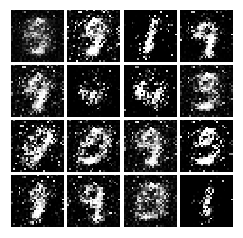


Iter: 1000, D: 1.064, G:1.623
Iter: 1050, D: 1.134, G:1.145
Iter: 1100, D: 1.261, G:1.343
Iter: 1150, D: 1.051, G:1.136
Iter: 1200, D: 1.228, G:1.183


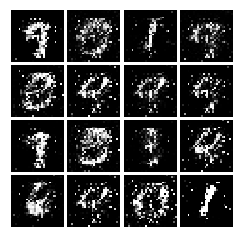


Iter: 1250, D: 1.136, G:1.043
Iter: 1300, D: 1.199, G:1.001
Iter: 1350, D: 1.425, G:0.8637
Iter: 1400, D: 1.319, G:0.9318
Iter: 1450, D: 1.21, G:0.8987


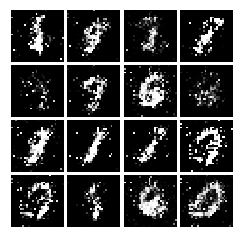


Iter: 1500, D: 1.291, G:0.8879
Iter: 1550, D: 1.226, G:1.006
Iter: 1600, D: 1.276, G:0.7559
Iter: 1650, D: 1.233, G:0.8555
Iter: 1700, D: 1.415, G:1.004


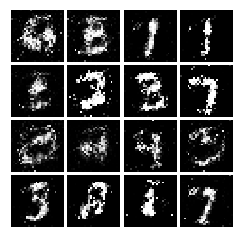


Iter: 1750, D: 1.504, G:0.8299
Iter: 1800, D: 1.299, G:0.874
Iter: 1850, D: 1.307, G:0.8684
Iter: 1900, D: 1.349, G:0.9231
Iter: 1950, D: 1.269, G:0.6132


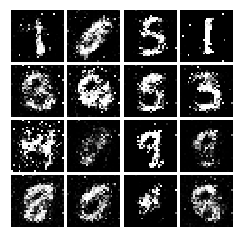


Iter: 2000, D: 1.42, G:0.8339
Iter: 2050, D: 1.299, G:0.9021
Iter: 2100, D: 1.303, G:0.9351
Iter: 2150, D: 1.31, G:0.7859
Iter: 2200, D: 1.35, G:0.8065


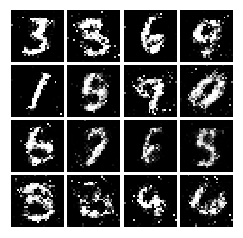


Iter: 2250, D: 1.331, G:0.799
Iter: 2300, D: 1.267, G:0.8308
Iter: 2350, D: 1.298, G:0.7988
Iter: 2400, D: 1.324, G:0.8976
Iter: 2450, D: 1.293, G:0.8095


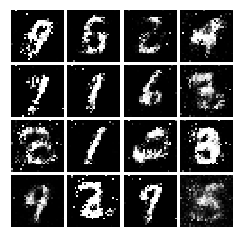


Iter: 2500, D: 1.27, G:0.7918
Iter: 2550, D: 1.249, G:0.5127
Iter: 2600, D: 1.262, G:0.8223
Iter: 2650, D: 1.257, G:0.8192
Iter: 2700, D: 1.319, G:0.9263


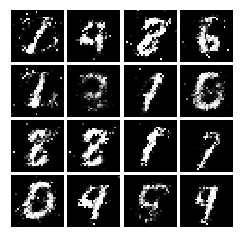


Iter: 2750, D: 1.313, G:0.981
Iter: 2800, D: 1.314, G:0.8533
Iter: 2850, D: 1.426, G:0.8203
Iter: 2900, D: 1.356, G:0.8895
Iter: 2950, D: 1.259, G:0.8507


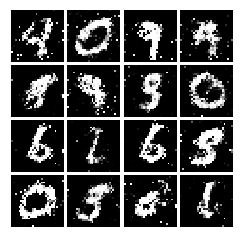


Iter: 3000, D: 1.273, G:0.8864
Iter: 3050, D: 1.288, G:0.9389
Iter: 3100, D: 1.282, G:0.7881
Iter: 3150, D: 1.337, G:0.7217
Iter: 3200, D: 1.276, G:0.7427


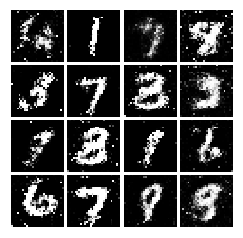


Iter: 3250, D: 1.306, G:0.8215
Iter: 3300, D: 1.316, G:0.8414
Iter: 3350, D: 1.306, G:0.8324
Iter: 3400, D: 1.281, G:0.8824
Iter: 3450, D: 1.297, G:0.7526


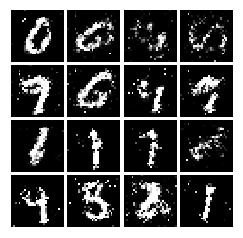


Iter: 3500, D: 1.305, G:0.7783
Iter: 3550, D: 1.356, G:0.8463
Iter: 3600, D: 1.313, G:0.7846
Iter: 3650, D: 1.354, G:0.7398
Iter: 3700, D: 1.369, G:0.74


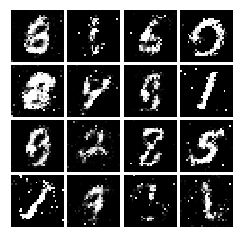


Iter: 3750, D: 1.271, G:0.8904
Iter: 3800, D: 1.263, G:0.8501
Iter: 3850, D: 1.289, G:0.8693
Iter: 3900, D: 1.286, G:0.83
Iter: 3950, D: 1.357, G:0.8582


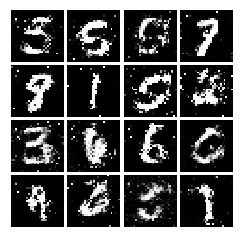


Iter: 4000, D: 1.285, G:0.786
Iter: 4050, D: 1.351, G:0.9133
Iter: 4100, D: 1.348, G:0.8876
Iter: 4150, D: 1.285, G:0.7807
Iter: 4200, D: 1.312, G:0.8286


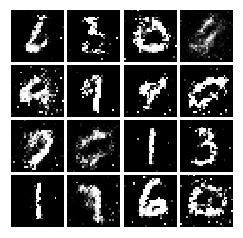


Iter: 4250, D: 1.313, G:0.8409
Final images


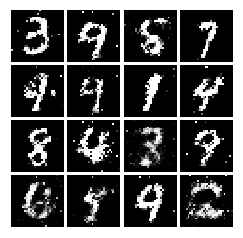

In [49]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [15]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    D_loss = 0.5 * (tf.reduce_mean(tf.square(score_real - 1)) + tf.reduce_mean(tf.square(score_fake)))
    G_loss = 0.5 * tf.reduce_mean(tf.square(score_fake - 1))
    pass
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [16]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [17]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

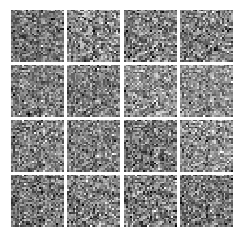


Iter: 0, D: 0.6483, G:0.3869
Iter: 50, D: 0.01225, G:0.7405
Iter: 100, D: 0.02745, G:0.6977
Iter: 150, D: 0.1563, G:0.5815
Iter: 200, D: 0.09083, G:0.2692


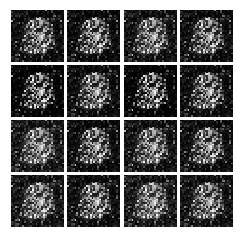


Iter: 250, D: 0.1016, G:0.5156
Iter: 300, D: 0.1845, G:0.2811
Iter: 350, D: 0.07072, G:0.3307
Iter: 400, D: 0.1333, G:0.3195
Iter: 450, D: 0.1326, G:0.4061


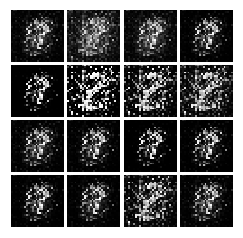


Iter: 500, D: 0.1628, G:0.2225
Iter: 550, D: 0.085, G:0.4575
Iter: 600, D: 0.1134, G:0.4202
Iter: 650, D: 0.1307, G:0.4668
Iter: 700, D: 0.163, G:0.3978


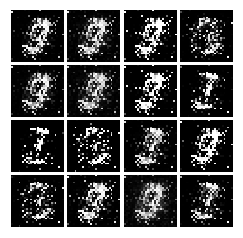


Iter: 750, D: 0.07572, G:0.8383
Iter: 800, D: 0.1414, G:0.3465
Iter: 850, D: 0.136, G:0.3616
Iter: 900, D: 0.2952, G:0.2138
Iter: 950, D: 0.1861, G:0.2902


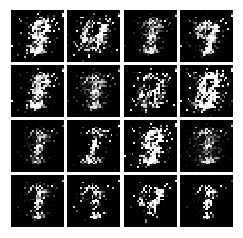


Iter: 1000, D: 0.1756, G:0.2529
Iter: 1050, D: 0.156, G:0.3471
Iter: 1100, D: 0.1702, G:0.3089
Iter: 1150, D: 0.1972, G:0.384
Iter: 1200, D: 0.1461, G:0.3627


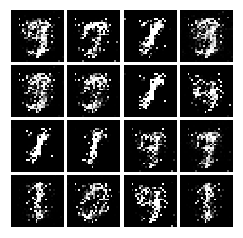


Iter: 1250, D: 0.1902, G:0.5066
Iter: 1300, D: 0.1569, G:0.2909
Iter: 1350, D: 0.1739, G:0.2392
Iter: 1400, D: 0.1549, G:0.2688
Iter: 1450, D: 0.1753, G:0.2269


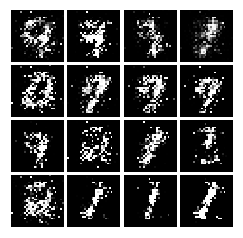


Iter: 1500, D: 0.1715, G:0.2899
Iter: 1550, D: 0.2381, G:0.1372
Iter: 1600, D: 0.2398, G:0.2439
Iter: 1650, D: 0.1863, G:0.4561
Iter: 1700, D: 0.2604, G:0.2726


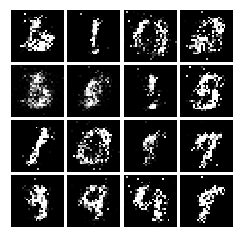


Iter: 1750, D: 0.204, G:0.1913
Iter: 1800, D: 0.1949, G:0.2015
Iter: 1850, D: 0.2113, G:0.2122
Iter: 1900, D: 0.1929, G:0.2834
Iter: 1950, D: 0.3882, G:0.01974


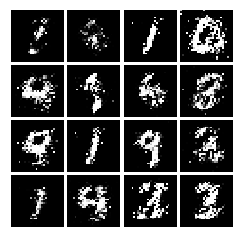


Iter: 2000, D: 0.2005, G:0.1906
Iter: 2050, D: 0.2169, G:0.1908
Iter: 2100, D: 0.1964, G:0.2021
Iter: 2150, D: 0.2155, G:0.1913
Iter: 2200, D: 0.2134, G:0.1687


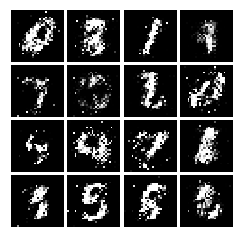


Iter: 2250, D: 0.2238, G:0.2063
Iter: 2300, D: 0.2115, G:0.1599
Iter: 2350, D: 0.2175, G:0.184
Iter: 2400, D: 0.2246, G:0.199
Iter: 2450, D: 0.2277, G:0.1535


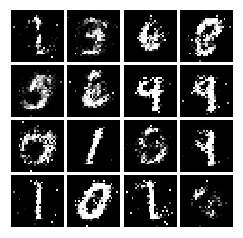


Iter: 2500, D: 0.2141, G:0.1576
Iter: 2550, D: 0.2233, G:0.1762
Iter: 2600, D: 0.2199, G:0.2013
Iter: 2650, D: 0.2243, G:0.1846
Iter: 2700, D: 0.2185, G:0.1625


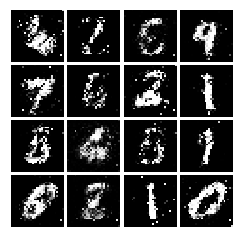


Iter: 2750, D: 0.2358, G:0.1633
Iter: 2800, D: 0.2174, G:0.1903
Iter: 2850, D: 0.2265, G:0.1872
Iter: 2900, D: 0.2375, G:0.1777
Iter: 2950, D: 0.237, G:0.1852


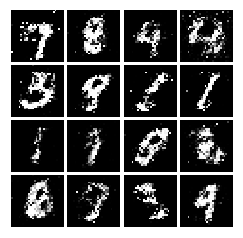


Iter: 3000, D: 0.2303, G:0.1775
Iter: 3050, D: 0.2337, G:0.1629
Iter: 3100, D: 0.2382, G:0.1697
Iter: 3150, D: 0.2433, G:0.16
Iter: 3200, D: 0.2162, G:0.1798


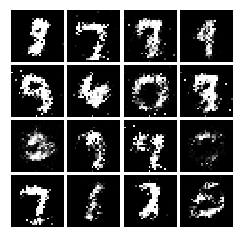


Iter: 3250, D: 0.2295, G:0.1568
Iter: 3300, D: 0.2246, G:0.1542
Iter: 3350, D: 0.243, G:0.1696
Iter: 3400, D: 0.2448, G:0.1772
Iter: 3450, D: 0.2158, G:0.1691


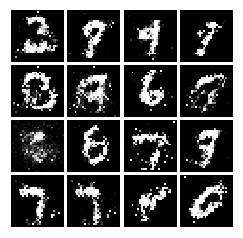


Iter: 3500, D: 0.2458, G:0.1646
Iter: 3550, D: 0.2376, G:0.1769
Iter: 3600, D: 0.2291, G:0.1673
Iter: 3650, D: 0.2112, G:0.1773
Iter: 3700, D: 0.238, G:0.1528


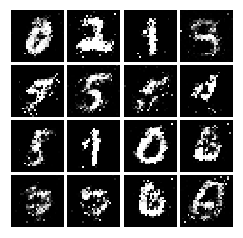


Iter: 3750, D: 0.2385, G:0.1735
Iter: 3800, D: 0.2247, G:0.1623
Iter: 3850, D: 0.2352, G:0.1689
Iter: 3900, D: 0.2551, G:0.143
Iter: 3950, D: 0.2376, G:0.1719


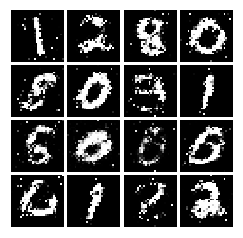


Iter: 4000, D: 0.2348, G:0.1661
Iter: 4050, D: 0.2427, G:0.1759
Iter: 4100, D: 0.2221, G:0.1527
Iter: 4150, D: 0.2301, G:0.1701
Iter: 4200, D: 0.2377, G:0.1489


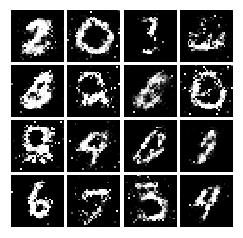


Iter: 4250, D: 0.2446, G:0.1433
Final images


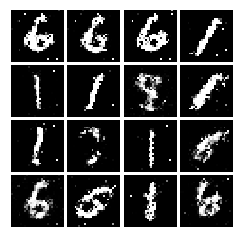

In [53]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [55]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.reshape(x, (-1, 28,28, 1))
        x = tf.layers.conv2d(x, 32, [5,5], activation=leaky_relu)
        x = tf.layers.max_pooling2d(x, (2, 2), (2, 2))
        x = tf.layers.conv2d(x, 64, [5,5], activation=leaky_relu)
        x = tf.layers.max_pooling2d(x, (2, 2), (2, 2))
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 4*4*64, use_bias=True, bias_initializer=tf.constant_initializer(0.0),
                            activation=tf.nn.relu)
        logits = tf.layers.dense(x, 1, use_bias=True, bias_initializer=tf.constant_initializer(0.0))
        pass
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [63]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        z = tf.layers.dense(z, 1024, use_bias=True, bias_initializer=tf.constant_initializer(0.0),
                           activation=tf.nn.relu)
        z = tf.layers.batch_normalization(z, training=True)
        z = tf.layers.dense(z, 7*7*128, use_bias=True, bias_initializer=tf.constant_initializer(0.0),
                           activation=tf.nn.relu)
        z = tf.layers.batch_normalization(z, training=True)
        z = tf.reshape(z, (-1, 7, 7, 128))
        z = tf.layers.conv2d_transpose(z, 64, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding='SAME')
        z = tf.layers.batch_normalization(z, training=True)
        img = tf.layers.conv2d_transpose(z, 1, [4, 4], strides=(2, 2), activation=tf.tanh, padding='SAME')
        
        pass
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [64]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

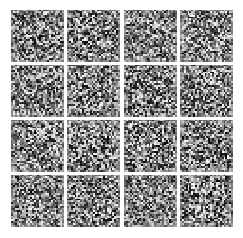


Iter: 0, D: 1.395, G:0.9842
Iter: 50, D: 0.3783, G:2.553
Iter: 100, D: 0.7168, G:0.7187
Iter: 150, D: 0.8616, G:1.061
Iter: 200, D: 0.9909, G:0.9846


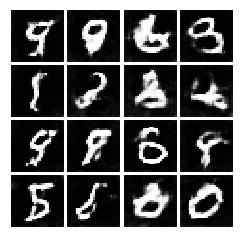


Iter: 250, D: 1.033, G:1.332
Iter: 300, D: 1.096, G:1.166
Iter: 350, D: 1.119, G:1.01
Iter: 400, D: 1.067, G:1.496
Iter: 450, D: 1.032, G:1.142


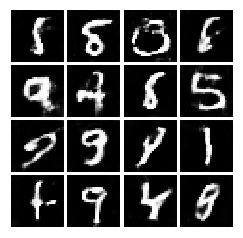


Iter: 500, D: 1.118, G:0.906
Iter: 550, D: 1.162, G:1.146
Iter: 600, D: 1.148, G:0.9838
Iter: 650, D: 1.232, G:1.109
Iter: 700, D: 1.207, G:1.129


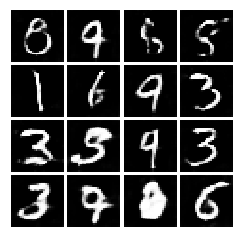


Iter: 750, D: 1.101, G:0.8807
Iter: 800, D: 1.18, G:1.021
Iter: 850, D: 1.224, G:1.007
Iter: 900, D: 1.139, G:1.031
Iter: 950, D: 1.587, G:0.6669


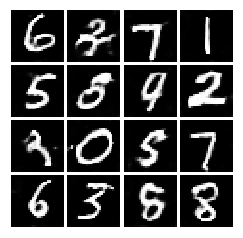


Iter: 1000, D: 1.16, G:0.9405
Iter: 1050, D: 1.205, G:1.004
Iter: 1100, D: 1.188, G:0.6532
Iter: 1150, D: 1.189, G:0.8271
Iter: 1200, D: 1.123, G:1.018


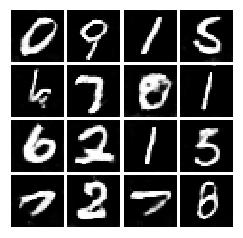


Iter: 1250, D: 1.074, G:0.8559
Final images


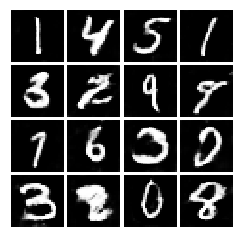

In [66]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=3)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

In [16]:
from cs231n.data_utils import load_CIFAR10
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
NUMTRAIN = X_train.shape[0]

X_train:  (50000, 32, 32, 3)
X_test:  (10000, 32, 32, 3)


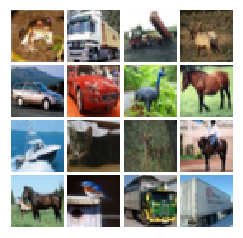

In [17]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

show_images(X_train[:16])

In [18]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

def leaky_relu(x, alpha=0.01):
    return tf.maximum(alpha*x,x)

def sample_noise(batch_size, dim):
    x = tf.random_uniform((batch_size, dim), minval=-1, maxval=1, dtype=tf.float32)
    return x

def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate,beta1 = beta1)
    return D_solver, G_solver

def get_loss(score_real, score_fake):
    G_loss = 0.5*tf.reduce_mean(tf.square(score_fake-1))
    D_loss = 0.5*tf.reduce_mean(tf.square(score_real-1) + tf.square(score_fake))
    return D_loss, G_loss

Total iterations: 7812


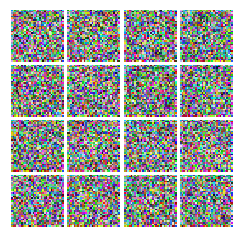

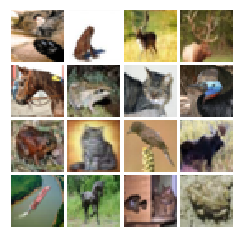


Iter: 0, D: 1.773, G:8.129
Iter: 50, D: 0.05056, G:0.576
Iter: 100, D: 0.03999, G:0.3787
Iter: 150, D: 0.1725, G:0.8696
Iter: 200, D: 0.3204, G:1.099


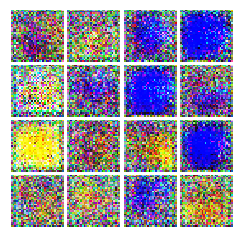

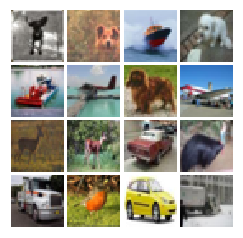


Iter: 250, D: 0.06454, G:0.7672
Iter: 300, D: 0.01214, G:0.529
Iter: 350, D: 0.008842, G:0.5044
Iter: 400, D: 0.009559, G:0.5385
Iter: 450, D: 0.01258, G:0.4491


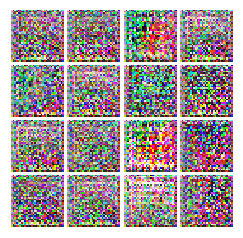

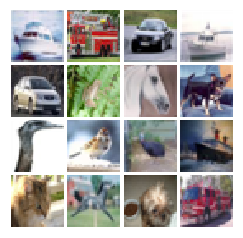


Iter: 500, D: 0.006836, G:0.5144
Iter: 550, D: 0.0345, G:0.7131
Iter: 600, D: 0.005999, G:0.4708
Iter: 650, D: 0.00668, G:0.4496
Iter: 700, D: 0.01244, G:0.5252


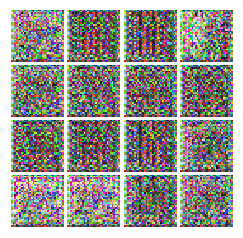

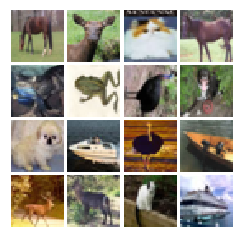


Iter: 750, D: 0.05077, G:0.7005
Iter: 800, D: 0.02725, G:0.3618
Iter: 850, D: 0.00415, G:0.5428
Iter: 900, D: 0.07975, G:0.2802
Iter: 950, D: 0.004943, G:0.5001


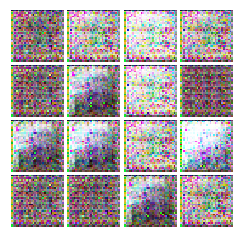

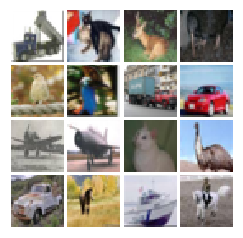


Iter: 1000, D: 0.1308, G:0.2753
Iter: 1050, D: 0.006496, G:0.5369
Iter: 1100, D: 0.2448, G:0.2314
Iter: 1150, D: 0.00461, G:0.5161
Iter: 1200, D: 0.01879, G:0.6023


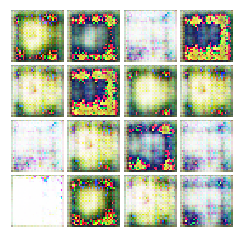

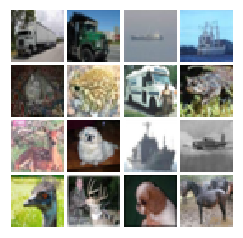


Iter: 1250, D: 0.01361, G:0.5442
Iter: 1300, D: 0.01818, G:0.5483
Iter: 1350, D: 0.03933, G:0.4056
Iter: 1400, D: 0.004206, G:0.489
Iter: 1450, D: 0.007346, G:0.5072


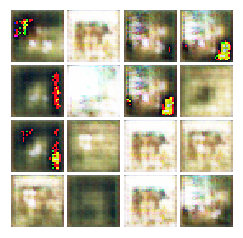

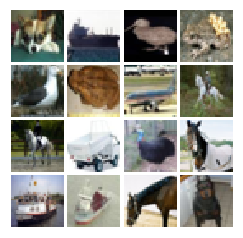


Iter: 1500, D: 0.004637, G:0.4993
Iter: 1550, D: 0.005188, G:0.461
Iter: 1600, D: 0.007319, G:0.5332
Iter: 1650, D: 0.005084, G:0.5287
Iter: 1700, D: 0.011, G:0.5096


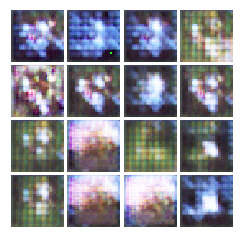

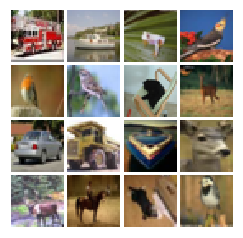


Iter: 1750, D: 0.03024, G:0.6585
Iter: 1800, D: 0.04425, G:0.6838
Iter: 1850, D: 0.003572, G:0.5073
Iter: 1900, D: 0.03022, G:0.5642
Iter: 1950, D: 0.05275, G:0.6146


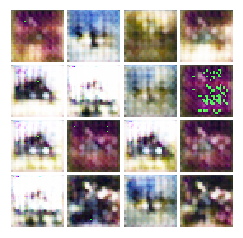

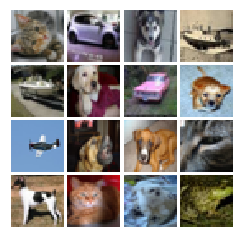


Iter: 2000, D: 0.03241, G:0.4888
Iter: 2050, D: 0.01485, G:0.5333
Iter: 2100, D: 0.1219, G:0.6577
Iter: 2150, D: 0.1134, G:0.5166
Iter: 2200, D: 0.08028, G:0.5045


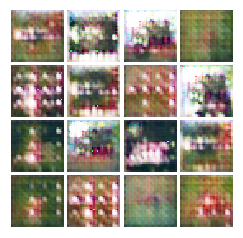

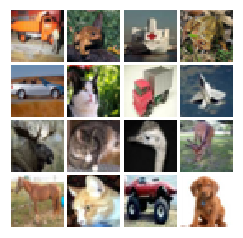


Iter: 2250, D: 0.1711, G:0.1925
Iter: 2300, D: 0.01304, G:0.4981
Iter: 2350, D: 0.02723, G:0.4512
Iter: 2400, D: 0.1406, G:0.2498
Iter: 2450, D: 0.1061, G:0.6789


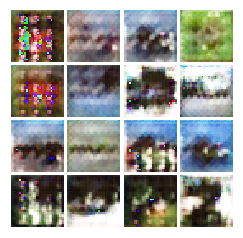

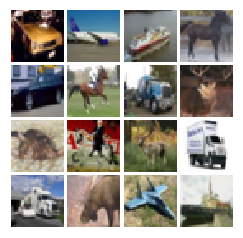


Iter: 2500, D: 0.007154, G:0.5307
Iter: 2550, D: 0.03261, G:0.4278
Iter: 2600, D: 0.07793, G:0.5754
Iter: 2650, D: 0.07382, G:0.209
Iter: 2700, D: 0.2279, G:0.2384


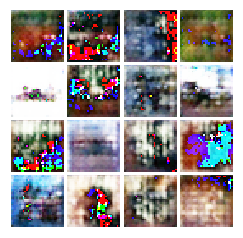

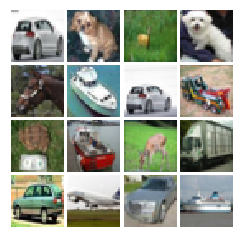


Iter: 2750, D: 0.1757, G:0.6141
Iter: 2800, D: 0.03316, G:0.4794
Iter: 2850, D: 0.1228, G:0.4184
Iter: 2900, D: 0.06274, G:0.4113
Iter: 2950, D: 0.1023, G:0.4575


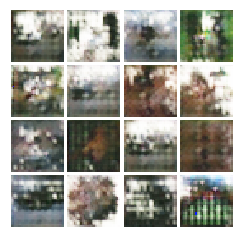

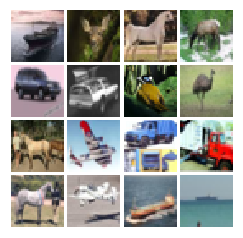


Iter: 3000, D: 0.07271, G:0.154
Iter: 3050, D: 0.09587, G:0.5754
Iter: 3100, D: 0.08927, G:0.5579
Iter: 3150, D: 0.01221, G:0.5608
Iter: 3200, D: 0.09337, G:0.5014


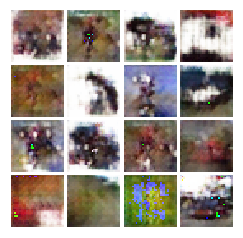

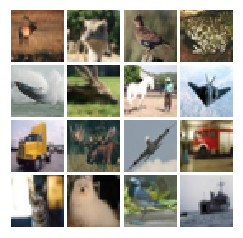


Iter: 3250, D: 0.06922, G:0.5471
Iter: 3300, D: 0.03948, G:0.406
Iter: 3350, D: 0.06241, G:0.4954
Iter: 3400, D: 0.009294, G:0.5706
Iter: 3450, D: 0.003978, G:0.5021


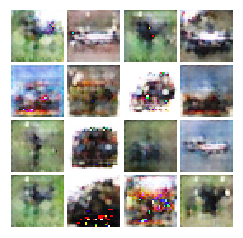

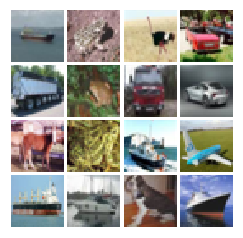


Iter: 3500, D: 0.1136, G:0.444
Iter: 3550, D: 0.4036, G:0.591
Iter: 3600, D: 0.01256, G:0.4958
Iter: 3650, D: 0.01123, G:0.4628
Iter: 3700, D: 0.007721, G:0.4809


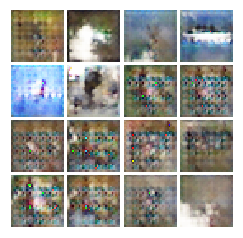

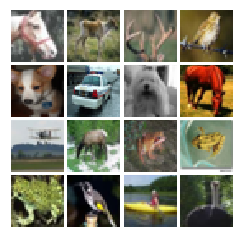


Iter: 3750, D: 0.005119, G:0.4887
Iter: 3800, D: 0.004557, G:0.4962
Iter: 3850, D: 0.002167, G:0.505
Iter: 3900, D: 0.003113, G:0.4985
Iter: 3950, D: 0.002531, G:0.5216


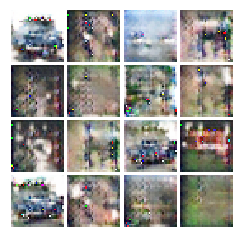

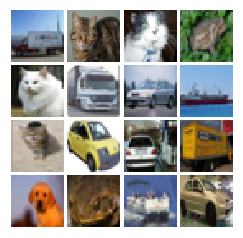


Iter: 4000, D: 0.002122, G:0.5128
Iter: 4050, D: 0.00112, G:0.503
Iter: 4100, D: 0.001799, G:0.499
Iter: 4150, D: 0.00154, G:0.4985
Iter: 4200, D: 0.00127, G:0.5048


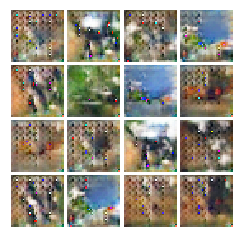

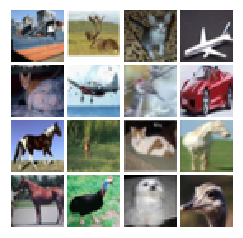


Iter: 4250, D: 0.001104, G:0.4965
Iter: 4300, D: 0.000822, G:0.5021
Iter: 4350, D: 0.0008283, G:0.5003
Iter: 4400, D: 0.001117, G:0.4909
Iter: 4450, D: 0.007373, G:0.4712


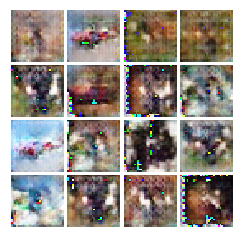

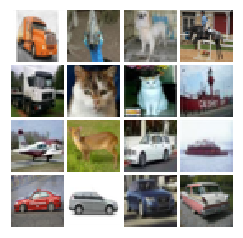


Iter: 4500, D: 0.001467, G:0.5
Iter: 4550, D: 0.0009918, G:0.4957
Iter: 4600, D: 0.001322, G:0.4972
Iter: 4650, D: 0.001105, G:0.4946
Iter: 4700, D: 0.001503, G:0.4872


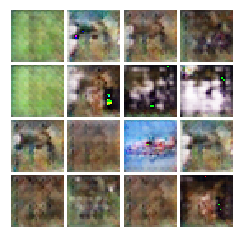

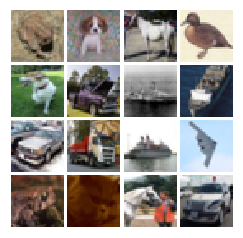


Iter: 4750, D: 0.3649, G:0.1931
Iter: 4800, D: 0.006594, G:0.4927
Iter: 4850, D: 0.004017, G:0.4963
Iter: 4900, D: 0.003846, G:0.5056
Iter: 4950, D: 0.157, G:0.2044


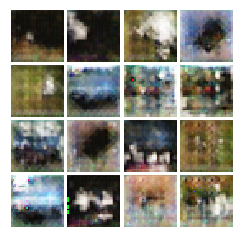

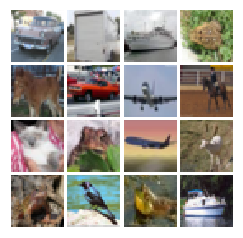


Iter: 5000, D: 0.1356, G:0.1091
Iter: 5050, D: 0.0495, G:0.3623
Iter: 5100, D: 0.06396, G:0.4905
Iter: 5150, D: 0.01163, G:0.4243
Iter: 5200, D: 0.02001, G:0.5584


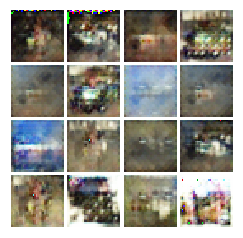

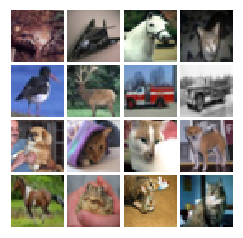


Iter: 5250, D: 0.01439, G:0.439
Iter: 5300, D: 0.02104, G:0.4757
Iter: 5350, D: 0.003074, G:0.4946
Iter: 5400, D: 0.00366, G:0.5337
Iter: 5450, D: 0.002289, G:0.495


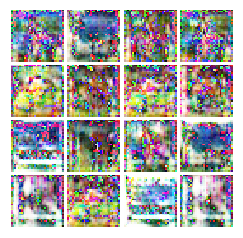

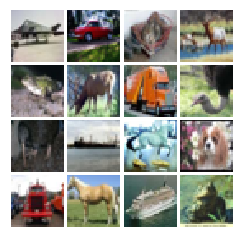


Iter: 5500, D: 0.002085, G:0.5323
Iter: 5550, D: 0.001732, G:0.5105
Iter: 5600, D: 0.001063, G:0.5311
Iter: 5650, D: 0.08333, G:0.582
Iter: 5700, D: 0.008338, G:0.4961


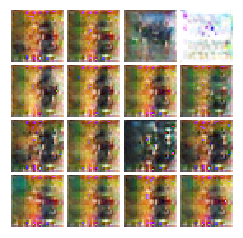

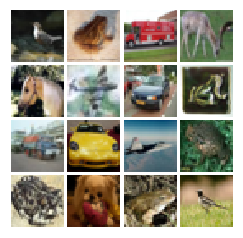


Iter: 5750, D: 0.0009601, G:0.5224
Iter: 5800, D: 0.0007658, G:0.4936
Iter: 5850, D: 0.001551, G:0.5152
Iter: 5900, D: 0.000614, G:0.4982
Iter: 5950, D: 0.01922, G:0.416


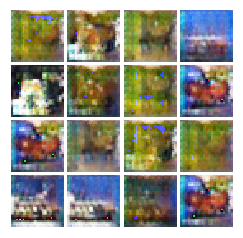

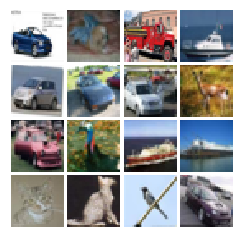


Iter: 6000, D: 0.3912, G:0.302
Iter: 6050, D: 0.004659, G:0.5018
Iter: 6100, D: 0.002254, G:0.5087
Iter: 6150, D: 0.002905, G:0.5242
Iter: 6200, D: 0.002854, G:0.5115


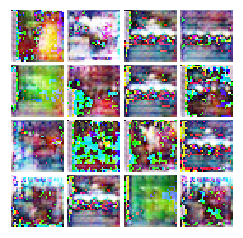

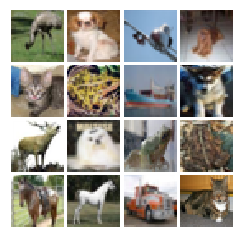


Iter: 6250, D: 0.002883, G:0.5175
Iter: 6300, D: 0.001193, G:0.5004
Iter: 6350, D: 0.00102, G:0.4975
Iter: 6400, D: 0.0109, G:0.4593
Iter: 6450, D: 0.002963, G:0.5079


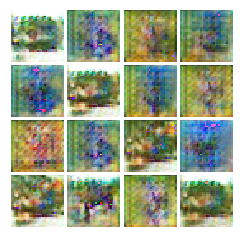

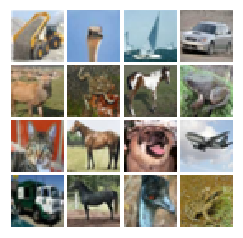


Iter: 6500, D: 0.01459, G:0.4022
Iter: 6550, D: 0.0007353, G:0.4958
Iter: 6600, D: 0.0007912, G:0.503
Iter: 6650, D: 0.00481, G:0.5394
Iter: 6700, D: 0.001282, G:0.4968


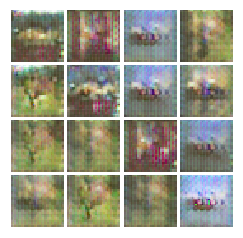

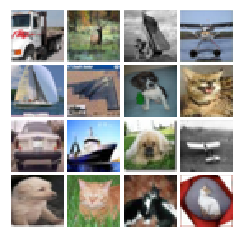


Iter: 6750, D: 0.001204, G:0.498
Iter: 6800, D: 0.001437, G:0.5178
Iter: 6850, D: 0.001649, G:0.4975
Iter: 6900, D: 0.01033, G:0.5373
Iter: 6950, D: 0.003911, G:0.5297


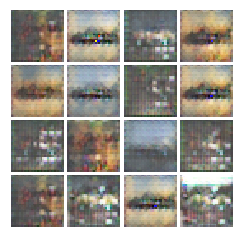

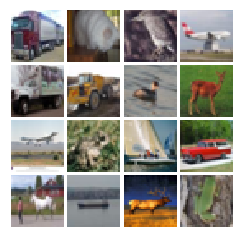


Iter: 7000, D: 0.000581, G:0.4992
Iter: 7050, D: 0.000702, G:0.5012
Iter: 7100, D: 0.03332, G:0.3742
Iter: 7150, D: 0.0006784, G:0.5085
Iter: 7200, D: 0.02204, G:0.4769


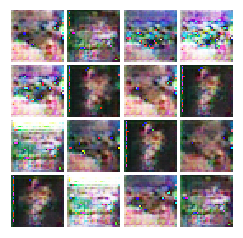

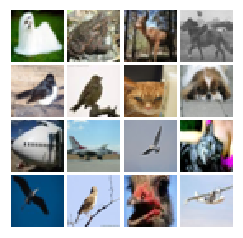


Iter: 7250, D: 0.0002985, G:0.4996
Iter: 7300, D: 0.0002498, G:0.4932
Iter: 7350, D: 0.001464, G:0.4925
Iter: 7400, D: 0.0008811, G:0.5234
Iter: 7450, D: 0.0006248, G:0.5041


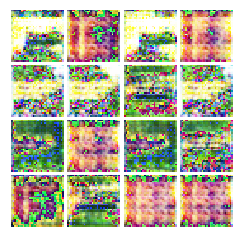

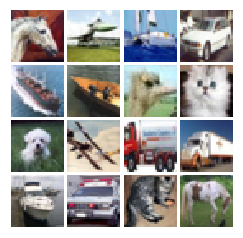


Iter: 7500, D: 0.0002881, G:0.4987
Iter: 7550, D: 0.0007052, G:0.4997
Iter: 7600, D: 0.0004441, G:0.5103
Iter: 7650, D: 0.0003182, G:0.5547
Iter: 7700, D: 0.0007805, G:0.4929


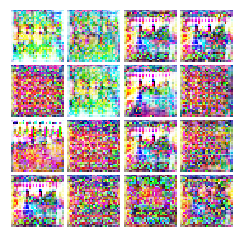

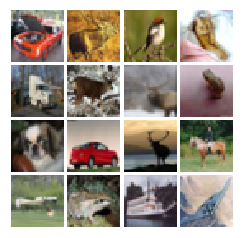


Iter: 7750, D: 0.0003719, G:0.507
Iter: 7800, D: 0.0006765, G:0.5046
Final images


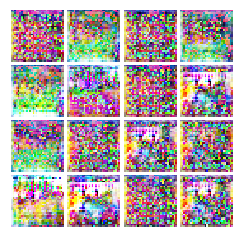

In [22]:
def discriminator(x):
    with tf.variable_scope("discriminator"):
        x = tf.layers.conv2d(x, 32, [4,4], activation=leaky_relu, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.layers.max_pooling2d(x, (2,2), (2,2))

        x = tf.layers.conv2d(x, 64, [4,4], activation=leaky_relu, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.layers.max_pooling2d(x, (2,2), (2,2))

        x = tf.layers.conv2d(x, 128, [4,4], activation=leaky_relu, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.layers.max_pooling2d(x, (2,2), (2,2))

        x = tf.layers.conv2d(x, 256, [4,4], activation=leaky_relu, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.layers.max_pooling2d(x, (2,2), (2,2))

        x = tf.layers.conv2d(x, 512, [3,3], activation=leaky_relu, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.layers.max_pooling2d(x, (2,2), (2,2))
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 512, use_bias=True, bias_initializer=tf.constant_initializer(0.0),
                            activation=leaky_relu)
        x = tf.layers.dense(x, 1)
        return x

def generator(z):
    with tf.variable_scope("generator"):
        z = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        z = tf.layers.batch_normalization(z, training=True)

        z = tf.layers.dense(z, 2 * 2 * 512, activation=tf.nn.relu)
        z = tf.layers.batch_normalization(z, training=True)

        z = tf.reshape(z, (-1, 2, 2, 512))

        z = tf.layers.conv2d_transpose(z, 256, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding='SAME')
        z = tf.layers.batch_normalization(z, training=True)

        z = tf.layers.conv2d_transpose(z, 128, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding='SAME')
        z = tf.layers.batch_normalization(z, training=True)

        z = tf.layers.conv2d_transpose(z, 64, [4, 4], strides=(2, 2), activation=tf.nn.relu, padding='SAME')
        z = tf.layers.batch_normalization(z, training=True)

        img = tf.layers.conv2d_transpose(z, 3, [4, 4], strides=(2, 2), activation=tf.tanh, padding='SAME')
        return img

tf.reset_default_graph()

batch_size = 128
noise_dim = 96

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
z = sample_noise(batch_size, noise_dim)

G_sample = generator(z)

with tf.variable_scope("") as scope:
    scores_real = discriminator(x)
    scope.reuse_variables()
    scores_fake = discriminator(G_sample)

# variables for generator and discriminator
D_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
# get the optimizers
D_solver, G_solver = get_solvers()
# get the loss
D_loss, G_loss = get_loss(scores_real, scores_fake)

# batch normalization in tensorflow requires this extra dependency
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')):
    D_train_step = D_solver.minimize(D_loss, var_list=D_variables)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')):
    G_train_step = G_solver.minimize(G_loss, var_list=G_variables)

# a giant helper function
def run_gan(sess, G_train_step, G_loss, D_train_step, D_loss,
            show_every=250, print_every=50, batch_size=128, num_epoch=10):

    # compute the number of iterations we need
    max_iter = int(X_train.shape[0] * num_epoch / batch_size)
    print ('Total iterations: %s' % max_iter)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            rand_indices = np.random.choice(np.arange(49000), batch_size)
            minibatch = X_train[rand_indices]
            samples = sess.run(G_sample, feed_dict = {x:minibatch})
            show_images(samples[:16])
            plt.show()
            show_images(minibatch[:16])
            plt.show()
            print()

        rand_indices = np.random.choice(np.arange(49000),batch_size)
        minibatch = X_train[rand_indices]
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))

    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_gan(sess,G_train_step,G_loss,D_train_step,D_loss, num_epoch=20)

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [67]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = tf.layers.conv2d(x, filters=64, kernel_size=[4, 4], strides=[2, 2], activation = leaky_relu)
        x = tf.layers.conv2d(x, filters=128, kernel_size=[4, 4], strides=[2, 2], activation=leaky_relu)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(inputs=x, units=1024, activation=leaky_relu)
        logits = tf.layers.dense(x, 1)
        pass
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [ ]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [ ]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = 0
    x_hat = 0

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = None

    grad_norm = None
    grad_pen = None



    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)